**This notebook normalizes all image patches in data/patches/ based on the [this](https://github.com/schaugf/HEnorm_python) method.**

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm_notebook

In [2]:
dirData = 'data/patches/'
ImageFiles = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dirData):
    for file in f:
        if '.png' in file:
            ImageFiles.append(os.path.join(r, file))
len(ImageFiles)

430821

In [3]:
def normalizeStaining(img_path, saveDir=None, returnStains=False, returnOriginal=False, Io=240, alpha=1, beta=0.15):
    ''' Normalize staining appearence of H&E stained images.
    
    Input:
        img_path: Input image path
        saveDir (String): Normalized image save directory (default = None)
        returnStains (Bool): return additional H & E stain images if saveFile is not None, these are also saved. (default=False) 
        returnOriginal (Bool): return unnormalized image (default=False)
        Io: (optional) transmitted light intensity
        
    Output:
        Inorm: normalized image
        H: hematoxylin image
        E: eosin image
        Orig: Unnormalized image
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    maxCRef = np.array([1.9705, 1.0308])
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    rimg = np.reshape(img.astype(np.float), (-1,3))
    
    # calculate optical density
    OD = -np.log((rimg+1)/Io)
    
    # remove transparent pixels
    ODhat = np.array([i for i in OD if not any(i<beta)])
        
    # compute eigenvectors
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    C2 = np.array([C[:,i]/maxC*maxCRef for i in range(C.shape[1])]).T
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # unmix hematoxylin and eosin
    H,E = None,None
    if returnStains:
        H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
        H[H>255] = 254
        H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

        E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
        E[E>255] = 254
        E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    if saveDir is not None:
        #extract name of the file
        base=os.path.basename(img_path)
        name_wo_ext = os.path.splitext(base)[0]
        fn = os.path.join(saveDir, name_wo_ext)
        print(fn+'.png')
        cv2.imwrite(fn+'.png', Inorm)
        if returnStains:
            cv2.imwrite(fn+'_H.png', H)
            cv2.imwrite(fn+'_.Epng', E)

    # construct return tuple
    returnTuple = (Inorm,)
    if returnStains:
        returnTuple = returnTuple +  (H, E)
    if returnOriginal:
        returnTuple = returnTuple + (img,)
        
    return returnTuple

**Compare cython vs. python normalization**

In [10]:
from utils import normStainImg

In [3]:
from utils import normalizeStaining_cython

In [15]:
%%timeit
save_dir = 'data/norm_patches_test/'
normStainImg.normalizeStaining(ImageFiles[5], saveDir=save_dir)

496 ms ± 42.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
save_dir = 'data/norm_patches_test/'
normalizeStaining_cython.normalizeStaining(ImageFiles[5], saveDir=save_dir)

496 ms ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


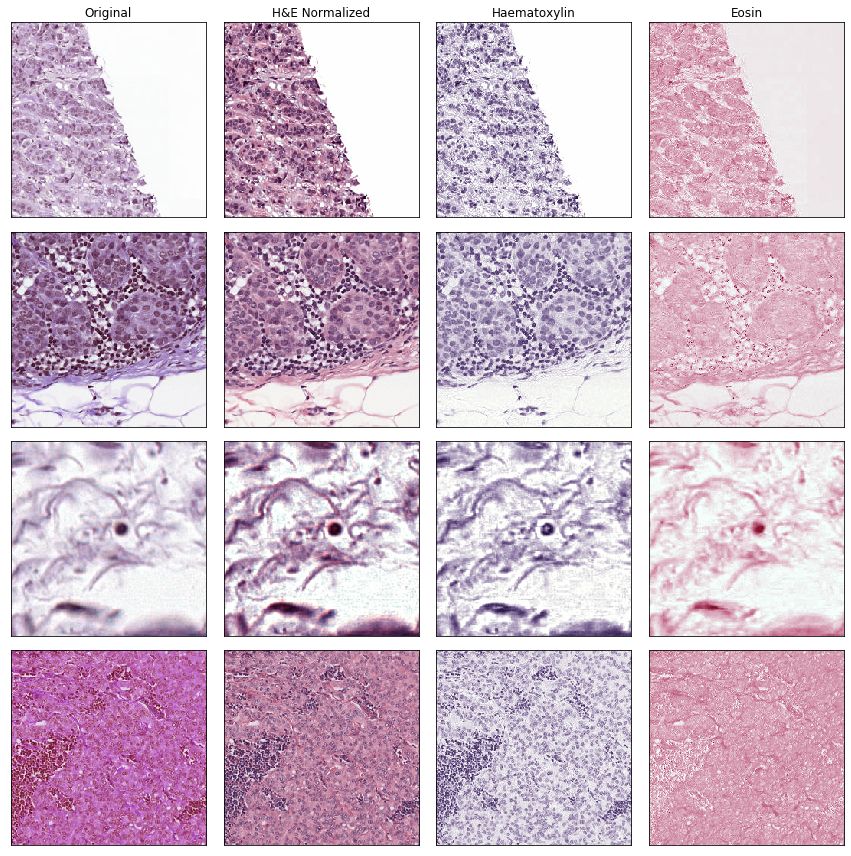

In [35]:
n_samples = 4

fig, ax = plt.subplots(n_samples,4, figsize=(12,3*n_samples))
for i in range(n_samples):
    normalized_img, H_img, E_img, original_img = normalizeStaining(ImageFiles[(i+1)*32453], returnStains=True, returnOriginal=True)

    ax[i,0].imshow(original_img)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    
    ax[i,1].imshow(normalized_img)
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    
    ax[i,2].imshow(H_img)
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])
    
    ax[i,3].imshow(E_img)
    ax[i,3].set_xticks([])
    ax[i,3].set_yticks([])

ax[0,0].set_title('Original')
ax[0,1].set_title('H&E Normalized')
ax[0,2].set_title('Haematoxylin')
ax[0,3].set_title('Eosin')

plt.tight_layout()

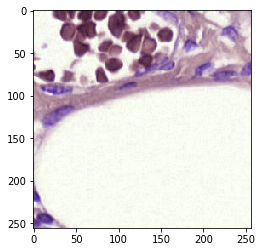

In [10]:
# error case, this capture was not normalized
im = cv2.imread('data/norm_patches/1066240043904_0.png')
plt.imshow(im)

## After producing the normalizations
Some files are still missing so lets retry in single thread

In [2]:
dirDataNorm = 'data/norm_patches/'
NormImageFiles = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dirDataNorm):
    for file in f:
        if '.png' in file:
            NormImageFiles.append(os.path.join(r, file))
len(NormImageFiles)

430821

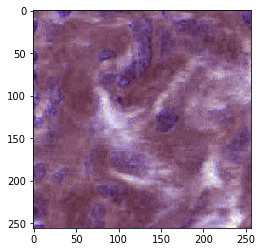

In [9]:
im = cv2.imread(NormImageFiles[1000])#len(NormImageFiles) - 1000])
plt.imshow(im)

In [5]:
from tqdm import tqdm_notebook

In [6]:
for f in tqdm_notebook(ImageFiles,'Normalizing...'):
    normalizeStaining_cython.normalizeStaining(f)

Error in data/patches/98000919040049920_3.png, copying this to output file unaltered.
Error in data/patches/88000357120077952_2.png, copying this to output file unaltered.
Error in data/patches/88000506880030976_0.png, copying this to output file unaltered.


/home/jonijuvonen/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/home/jonijuvonen/.conda/envs/fastai/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/jonijuvonen/.conda/envs/fastai/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Eigenvalues did not converge in data/patches/82000085760086912_3.png, copying this to output file unaltered.
Eigenvalues did not converge in data/patches/82000303360087936_2.png, copying this to output file unaltered.
Error in data/patches/82000619520062976_2.png, copying this to output file unaltered.
Error in data/patches/82000619520062976_3.png, copying this to output file unaltered.
Eigenvalues did not converge in data/patches/87000665600037376_3.png, copying this to output file unaltered.
Error in data/patches/87000232960119552_2.png, copying this to output file unaltered.
Error in data/patches/87000152320116352_2.png, copying this to output file unaltered.
Error in data/patches/87000714240103936_2.png, copying this to output file unaltered.
Error in data/patches/87000309760127488_2.png, copying this to output file unaltered.
Error in data/patches/87000743680013184_2.png, copying this to output file unaltered.
Error in data/patches/87000697600105856_2.png, copying this to output f